In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "SBP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn016511,MEEVGAQVAPPIFMHQNLGGRFCEGHSMTKKRGQPNFHHQQPRLTS...,916,1
1,Achn017541,MGSVSGSSSYGGQGMKGDFSVDLKLGHVVNAGNESTDNLQVPSVPK...,319,1
2,Achn039041,MDWDWDLTELGQEDLVGSSSLEAHKNGGGFSVELKLGGLGDLGDGS...,376,1
3,Achn064091,MGSGSSSSSDSLHGLKFGHKIYFDDSGGGGPPSASALGGRPPAAAP...,349,1
4,Achn082431,MDPPTPPPPPPLSDMENPIPHYDDPLWNWSDFLDFGIDAEAQFSIS...,849,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
581,0.004822,0.0,0.002893,0.001929,0.000964,0.005786,0.000964,0.000964,0.002893,0.006750,...,0.002893,0.000964,0.00000,0.000964,0.001929,0.000964,0.001929,0.000000,0.0,0.001929
580,0.001972,0.0,0.001972,0.003945,0.001972,0.003945,0.000000,0.000000,0.000000,0.005917,...,0.000000,0.000000,0.00000,0.000000,0.003945,0.001972,0.001972,0.000000,0.0,0.000000
463,0.000000,0.0,0.000000,0.002849,0.000000,0.008547,0.000000,0.000000,0.005698,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.008547,0.000000,0.000000,0.000000,0.0,0.000000
4218,0.019277,0.0,0.000000,0.007229,0.000000,0.007229,0.002410,0.000000,0.007229,0.004819,...,0.002410,0.002410,0.00241,0.007229,0.000000,0.004819,0.000000,0.002410,0.0,0.000000
4564,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.003788,0.000000,0.007576,0.011364,...,0.000000,0.003788,0.00000,0.000000,0.000000,0.000000,0.000000,0.003788,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (6648, 441)
X_test: (1663, 441)
y_train: (6648,)
y_test: (1663,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 38s 466ms/step - accuracy: 0.4844 - loss: 0.6931

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6122 - loss: 0.6853   

64/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6973 - loss: 0.6416

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7308 - loss: 0.5981 - val_accuracy: 0.9541 - val_loss: 0.1222


Epoch 2/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.1034

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9620 - loss: 0.1011

62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9660 - loss: 0.0959

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9678 - loss: 0.0925 - val_accuracy: 0.9737 - val_loss: 0.0754


Epoch 3/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0591

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9756 - loss: 0.0795

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0690

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9800 - loss: 0.0660 - val_accuracy: 0.9744 - val_loss: 0.0738


Epoch 4/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.0899

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9779 - loss: 0.0579

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.0536

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9820 - loss: 0.0518 - val_accuracy: 0.9722 - val_loss: 0.0860


Epoch 5/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.0653

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.0483

62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0442

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0430 - val_accuracy: 0.9857 - val_loss: 0.0542


Epoch 6/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0043

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0230

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0265

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0282 - val_accuracy: 0.9827 - val_loss: 0.0557


Epoch 7/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0099

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0269

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0269

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0275 - val_accuracy: 0.9842 - val_loss: 0.0565


Epoch 8/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0033

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0106

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0153

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0178 - val_accuracy: 0.9827 - val_loss: 0.0553


Epoch 9/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0459

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0261

59/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0225

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0214 - val_accuracy: 0.9805 - val_loss: 0.0658


Epoch 10/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0088

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0259

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0221

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0204 - val_accuracy: 0.9805 - val_loss: 0.0835


Epoch 11/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0070

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0125

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0145 - val_accuracy: 0.9759 - val_loss: 0.0893


Epoch 12/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0126

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0193

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0174

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0176 - val_accuracy: 0.9782 - val_loss: 0.0843


Epoch 13/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0032

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0076

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0113

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0116 - val_accuracy: 0.9789 - val_loss: 0.0853


Epoch 14/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0046

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0077

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0095

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0096 - val_accuracy: 0.9805 - val_loss: 0.0742


Epoch 15/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8286e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0147    

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0222

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0232 - val_accuracy: 0.9737 - val_loss: 0.1061



[Train Accuracy: 99.15% - Test Accuracy: 96.63%]


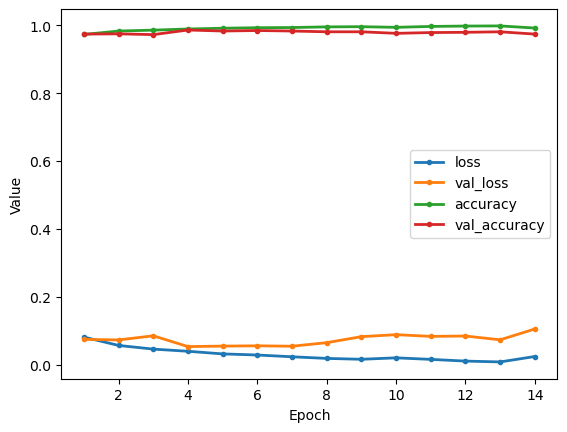

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
581,0.000000,0.0,0.0,0.000000,0.0,0.000965,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000965,0.0,0.000965,0.0,0.0,0.0
580,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
463,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4218,0.004831,0.0,0.0,0.002415,0.0,0.002415,0.0,0.0,0.0,0.002415,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4564,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (6648, 8869)
X_test: (1663, 8869)
y_train: (6648,)
y_test: (1663,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,270,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,313,985 (8.83 MB)

 Trainable params: 2,313,985 (8.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 41s 495ms/step - accuracy: 0.5156 - loss: 0.6931

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5294 - loss: 0.6927   

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5525 - loss: 0.6918

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5915 - loss: 0.6896

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6274 - loss: 0.6853

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6611 - loss: 0.6765

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6890 - loss: 0.6617

59/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7098 - loss: 0.6441

68/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7299 - loss: 0.6215

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7453 - loss: 0.6006

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7604 - loss: 0.5776 - val_accuracy: 0.9932 - val_loss: 0.0217


Epoch 2/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0103

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0104 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0102

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0104

34/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0113

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0126

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0135

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0143

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0151

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9969 - loss: 0.0156

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9967 - loss: 0.0160

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9967 - loss: 0.0161 - val_accuracy: 0.9932 - val_loss: 0.0140


Epoch 3/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0057

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9941 - loss: 0.0151 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9948 - loss: 0.0136

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9954 - loss: 0.0124

35/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9957 - loss: 0.0120

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9960 - loss: 0.0114

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9962 - loss: 0.0109

59/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9965 - loss: 0.0104

67/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9967 - loss: 0.0100

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9969 - loss: 0.0096

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9970 - loss: 0.0093

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9971 - loss: 0.0092 - val_accuracy: 0.9947 - val_loss: 0.0110


Epoch 4/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 8.7566e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015     

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0020

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0022

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0023

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0023

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0022

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0022

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0022

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0023

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0023

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.9985 - val_loss: 0.0063


Epoch 5/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 6.1400e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013     

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7078e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.6454e-04 - val_accuracy: 0.9970 - val_loss: 0.0078


Epoch 6/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.1310e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1591e-04 

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2332e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1925e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1647e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1777e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1595e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1446e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1551e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1808e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2027e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.2071e-04 - val_accuracy: 0.9962 - val_loss: 0.0096


Epoch 7/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 4.3221e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9025e-04 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5266e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2819e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1350e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0264e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9158e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8448e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7685e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6911e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.6378e-04 - val_accuracy: 0.9985 - val_loss: 0.0070


Epoch 8/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.8877e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3970e-04 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.3167e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7498e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8208e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7738e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6690e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6018e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5397e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4777e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4086e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.4001e-04 - val_accuracy: 0.9947 - val_loss: 0.0112


Epoch 9/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 3.7328e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4211e-04 

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1231e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9659e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7873e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5844e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4040e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2672e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1507e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0572e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.9639e-04 - val_accuracy: 0.9970 - val_loss: 0.0090


Epoch 10/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.7996e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0963e-05 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4408e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3856e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0295e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2783e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4158e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4620e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4316e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3871e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3306e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.3163e-05 - val_accuracy: 0.9985 - val_loss: 0.0080


Epoch 11/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.1594e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0422e-05 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4113e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0343e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7736e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8027e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7726e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0959e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3015e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4426e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.5520e-05 - val_accuracy: 0.9962 - val_loss: 0.0099


Epoch 12/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 3.4603e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5764e-05 

19/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1897e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1426e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6537e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.9868e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0920e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2767e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4605e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5691e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.6200e-05 - val_accuracy: 0.9985 - val_loss: 0.0077


Epoch 13/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.2787e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7773e-05 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7386e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8893e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1787e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3374e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4281e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4813e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5367e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5892e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.6316e-05 - val_accuracy: 0.9970 - val_loss: 0.0096


Epoch 14/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.3615e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8824e-05 

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0029e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0598e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0393e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0986e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1739e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2412e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2811e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3040e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.3156e-05 - val_accuracy: 0.9985 - val_loss: 0.0086



[Train Accuracy: 100.00% - Test Accuracy: 99.58%]

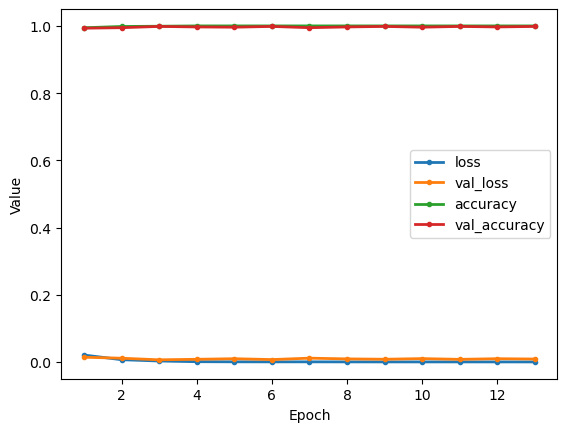

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYW,YYYX,YYYY
581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      38,838,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,879,233 (148.31 MB)

 Trainable params: 38,879,233 (148.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 56s 680ms/step - accuracy: 0.4844 - loss: 0.6932

 2/84 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.4961 - loss: 0.6931 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5061 - loss: 0.6930

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.5114 - loss: 0.6929

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5097 - loss: 0.6930

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5094 - loss: 0.6930

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.5109 - loss: 0.6929

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.5118 - loss: 0.6928

 9/84 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.5110 - loss: 0.6928

10/84 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.5098 - loss: 0.6928

11/84 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.5098 - loss: 0.6927

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.5097 - loss: 0.6927

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.5097 - loss: 0.6926

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.5098 - loss: 0.6925

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.5102 - loss: 0.6924

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.5103 - loss: 0.6923

17/84 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.5103 - loss: 0.6921

18/84 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.5101 - loss: 0.6920

19/84 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.5108 - loss: 0.6919

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.5125 - loss: 0.6917

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.5150 - loss: 0.6915

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.5180 - loss: 0.6913

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.5214 - loss: 0.6911

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.5251 - loss: 0.6908

25/84 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5290 - loss: 0.6906

26/84 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5330 - loss: 0.6903

27/84 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5371 - loss: 0.6900

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5413 - loss: 0.6896

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5456 - loss: 0.6893

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5499 - loss: 0.6889

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5543 - loss: 0.6885

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5585 - loss: 0.6880

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5627 - loss: 0.6875

34/84 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5668 - loss: 0.6870

35/84 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5709 - loss: 0.6865

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5750 - loss: 0.6860

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5790 - loss: 0.6853

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.5831 - loss: 0.6847

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.5870 - loss: 0.6840

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.5910 - loss: 0.6833

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.5949 - loss: 0.6825

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.5987 - loss: 0.6817

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6025 - loss: 0.6808

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.6063 - loss: 0.6799

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6099 - loss: 0.6790

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6135 - loss: 0.6780

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6171 - loss: 0.6769

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6205 - loss: 0.6758

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6240 - loss: 0.6747

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6273 - loss: 0.6735

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6307 - loss: 0.6722

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6339 - loss: 0.6709

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6371 - loss: 0.6695

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6402 - loss: 0.6681

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6433 - loss: 0.6666

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6463 - loss: 0.6651

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.6493 - loss: 0.6635

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.6522 - loss: 0.6618

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.6551 - loss: 0.6601

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.6579 - loss: 0.6584

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.6607 - loss: 0.6566

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.6634 - loss: 0.6548

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.6660 - loss: 0.6529

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.6687 - loss: 0.6509

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.6712 - loss: 0.6490

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.6738 - loss: 0.6470

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.6762 - loss: 0.6450

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6787 - loss: 0.6429

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6811 - loss: 0.6408

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6835 - loss: 0.6387

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6858 - loss: 0.6366

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6881 - loss: 0.6345

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6903 - loss: 0.6323

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6925 - loss: 0.6301

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6947 - loss: 0.6279

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6968 - loss: 0.6257

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6990 - loss: 0.6235

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7010 - loss: 0.6213

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7030 - loss: 0.6191

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7050 - loss: 0.6169

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7070 - loss: 0.6146

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7090 - loss: 0.6124

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7109 - loss: 0.6102

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7128 - loss: 0.6080

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.7146 - loss: 0.6058 - val_accuracy: 0.9835 - val_loss: 0.0398


Epoch 2/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.9844 - loss: 0.0461

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9883 - loss: 0.0394

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9887 - loss: 0.0381

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9886 - loss: 0.0383

 5/84 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9890 - loss: 0.0377

 6/84 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9895 - loss: 0.0368

 7/84 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9901 - loss: 0.0356

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9906 - loss: 0.0345

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9911 - loss: 0.0335 

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9915 - loss: 0.0325

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9919 - loss: 0.0316

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9922 - loss: 0.0307

13/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9925 - loss: 0.0300

14/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9928 - loss: 0.0293

15/84 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9931 - loss: 0.0286

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9933 - loss: 0.0281

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9934 - loss: 0.0277

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9935 - loss: 0.0274

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9937 - loss: 0.0270

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9938 - loss: 0.0267

21/84 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9939 - loss: 0.0264

22/84 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9940 - loss: 0.0261

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9941 - loss: 0.0259

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9942 - loss: 0.0256

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9943 - loss: 0.0254

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9944 - loss: 0.0252

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9945 - loss: 0.0250

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9945 - loss: 0.0248

29/84 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9946 - loss: 0.0246

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9947 - loss: 0.0244

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9947 - loss: 0.0243

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9948 - loss: 0.0241

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9948 - loss: 0.0239

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9949 - loss: 0.0237

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9949 - loss: 0.0235

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9950 - loss: 0.0234

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9950 - loss: 0.0233

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9950 - loss: 0.0231

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9950 - loss: 0.0230

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9951 - loss: 0.0228

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9951 - loss: 0.0227

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9951 - loss: 0.0226

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9951 - loss: 0.0225

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9951 - loss: 0.0223

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9952 - loss: 0.0222

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9952 - loss: 0.0221

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9952 - loss: 0.0220

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9952 - loss: 0.0219

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9952 - loss: 0.0218

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9953 - loss: 0.0217

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9953 - loss: 0.0216

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9953 - loss: 0.0215

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9953 - loss: 0.0214

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9953 - loss: 0.0213

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9954 - loss: 0.0212

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9954 - loss: 0.0211

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9954 - loss: 0.0210

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9954 - loss: 0.0209

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9954 - loss: 0.0208

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9955 - loss: 0.0207

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9955 - loss: 0.0206

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9955 - loss: 0.0205

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9955 - loss: 0.0204

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9955 - loss: 0.0203

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9956 - loss: 0.0202

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9956 - loss: 0.0201

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9956 - loss: 0.0200

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9956 - loss: 0.0199

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9956 - loss: 0.0198

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9956 - loss: 0.0198

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9957 - loss: 0.0197

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9957 - loss: 0.0196

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9957 - loss: 0.0195

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9957 - loss: 0.0195

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9957 - loss: 0.0194

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9957 - loss: 0.0193

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9957 - loss: 0.0193

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9957 - loss: 0.0192

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9958 - loss: 0.0191

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9958 - loss: 0.0191

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9958 - loss: 0.0190

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9958 - loss: 0.0189

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9958 - loss: 0.0189

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9958 - loss: 0.0188

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9958 - loss: 0.0188 - val_accuracy: 0.9955 - val_loss: 0.0168


Epoch 3/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 1.0000 - loss: 9.7611e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 0.0012    

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 0.0014

 4/84 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 0.0015

 5/84 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 0.0015

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 0.0015 

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 0.0015

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 0.0015

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 0.0015

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 0.0015

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 0.0015

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 0.0015

13/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 0.0015

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 0.0015

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 0.0015

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 0.0015

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 0.0015

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 0.0015

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 0.0015

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 0.0015

21/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 0.0015

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 0.0015

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 0.0015

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 0.0015

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 0.0015

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 0.0015

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 0.0015

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 0.0015

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 0.0015

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 0.0015

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 0.0015

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0015

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0015

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0015

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0015

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0015

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0015

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0015

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0015

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0015

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0015

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0015

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9999 - loss: 0.0015

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9999 - loss: 0.0015

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9999 - loss: 0.0015

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9999 - loss: 0.0015

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9999 - loss: 0.0015

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9999 - loss: 0.0015

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9999 - loss: 0.0015

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9999 - loss: 0.0016

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9999 - loss: 0.0016

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9999 - loss: 0.0016

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9999 - loss: 0.0016

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9999 - loss: 0.0016

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9999 - loss: 0.0016

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9999 - loss: 0.0016

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9999 - loss: 0.0016

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9999 - loss: 0.0016

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9999 - loss: 0.0016

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9999 - loss: 0.0016

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9999 - loss: 0.0016

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9999 - loss: 0.0016

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9999 - loss: 0.0016

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9999 - loss: 0.0016

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9999 - loss: 0.0016

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9999 - loss: 0.0016

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9999 - loss: 0.0016

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0016

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0016

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0016

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0016

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0016

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0016

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0016

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0016

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9999 - loss: 0.0016

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9999 - loss: 0.0016

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9999 - loss: 0.0016

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9999 - loss: 0.0016

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9999 - loss: 0.0016

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9999 - loss: 0.0016

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9998 - loss: 0.0016

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9998 - loss: 0.0016

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9998 - loss: 0.0016

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9947 - val_loss: 0.0170


Epoch 4/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 17s 215ms/step - accuracy: 1.0000 - loss: 8.5159e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 7.2249e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 7.0325e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 1.0000 - loss: 6.7531e-04 

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 6.5443e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 6.3847e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 6.2843e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 6.2610e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 6.2202e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 6.1504e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 6.0835e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 6.0288e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 6.0075e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 5.9838e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 5.9551e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 6.1012e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 6.2293e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 6.3335e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 6.4142e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 6.4787e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.5826e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.6727e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.7534e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.8259e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.8862e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.9349e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.9823e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 7.0209e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.0536e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.0812e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.1073e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.1302e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.1511e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.1679e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.1896e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.2125e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.2342e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.2510e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.2665e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.2783e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 7.2906e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 7.3004e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 7.3093e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.3151e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.3181e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.3189e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.3213e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.3217e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.3204e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.3175e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.3129e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.3067e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.3003e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.2934e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.2885e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.2854e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.2809e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.2775e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.2738e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.2689e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.2657e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.2617e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.2571e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.2515e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.2453e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.2387e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.2316e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.2345e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.2363e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.2373e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.2379e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.2382e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.2373e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.2361e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.2347e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.2336e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.2319e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.2293e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.2263e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.2228e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.2191e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.2147e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.2109e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.2070e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 7.2032e-04 - val_accuracy: 0.9955 - val_loss: 0.0166


Epoch 5/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 1.8396e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 1.0000 - loss: 2.6313e-04 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 2.7425e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.7820e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.7977e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.8186e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 2.8049e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 2.7988e-04 

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.8128e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 2.8165e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 2.8112e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 2.8285e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 2.8436e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 2.8703e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.8922e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 3.0187e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 3.1167e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 3.1927e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 3.2552e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 3.3097e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 3.3504e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 3.3942e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 3.4307e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.4610e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.4860e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.5082e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.5254e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.5414e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.5613e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.5769e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.5894e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.5993e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.6059e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.6181e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.6280e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.6357e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.6415e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.6451e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.6476e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.6742e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.6978e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.7191e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.7395e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.7576e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.7732e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.7873e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.7994e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.8104e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.8201e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.8289e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.8380e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.8457e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.8521e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.8584e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.8641e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.8688e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.8728e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.8762e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.8794e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.8823e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.8843e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.8876e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.8903e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.8928e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.8954e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.8976e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.8993e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.9006e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.9014e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.9018e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.9021e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.9018e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.9048e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.9074e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.9096e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.9113e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9129e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9143e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9153e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9160e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9165e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9166e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9162e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9158e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 3.9154e-04 - val_accuracy: 0.9947 - val_loss: 0.0175


Epoch 6/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 1.0000 - loss: 6.0822e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 5.8363e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 1.0000 - loss: 5.4947e-04 

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 5.1391e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 4.8567e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 4.6123e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 4.3990e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 4.2117e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 4.0496e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.9033e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 3.7755e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 3.6706e-04 

13/84 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 3.5715e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 3.4813e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 3.3985e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 3.3227e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 3.2522e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 3.1874e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 3.1283e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 3.0888e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 3.0502e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 3.0126e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 2.9754e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 2.9388e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 2.9073e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 2.8763e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 2.8456e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 2.8159e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 2.7890e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 2.7625e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.7399e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.7745e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.8124e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.8463e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.8758e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.9014e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.9242e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.9438e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.9609e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.9762e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.9898e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.0016e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.0114e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.0196e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.0266e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.0346e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.0417e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.0488e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.0548e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.0599e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.0642e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.0677e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.0713e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.0748e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.0778e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.0802e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.0819e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.0837e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.0851e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.0859e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.0862e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.0863e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.0860e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.0853e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.0844e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.0832e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.0815e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.0795e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.0771e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.0743e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.0713e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.0680e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.0643e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.0605e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.0565e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.0526e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.0485e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.0444e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.0400e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.0356e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.0309e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.0261e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.0211e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.0163e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 3.0115e-04 - val_accuracy: 0.9947 - val_loss: 0.0197


Epoch 7/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 1.0000 - loss: 6.3822e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 6.5744e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 6.4882e-05 

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 6.4576e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 6.5730e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 8.4172e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 9.5393e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.0409e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.1197e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.1806e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.2350e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.2751e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.3051e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3253e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.3419e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.3539e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3626e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3683e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3711e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3754e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3786e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3798e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3808e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3814e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3808e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3793e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3765e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3735e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3699e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3658e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3616e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3576e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3537e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3494e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3447e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.3400e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.3351e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.3304e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.3260e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.3287e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.3311e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.3331e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.3346e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.3358e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.3365e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.3369e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.3370e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.3371e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.3369e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.3369e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.3369e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.3369e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.3366e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.3361e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.3356e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.3348e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.3340e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.3330e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.3319e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.3312e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.3306e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.3300e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.3296e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.3301e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.3306e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.3312e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.3318e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.3325e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.3333e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.3341e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.3349e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.3355e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.3386e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.3414e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.3441e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.3467e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.3490e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.3512e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.3532e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.3549e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.3566e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.3581e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.3594e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.3607e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.3620e-04 - val_accuracy: 0.9932 - val_loss: 0.0208


Epoch 8/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 1.0000 - loss: 5.8695e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 1.0000 - loss: 6.5845e-05 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 1.0000 - loss: 6.6740e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 1.0000 - loss: 6.7281e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 1.0000 - loss: 7.0028e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 1.0000 - loss: 7.2164e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 1.0000 - loss: 7.2782e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 1.0000 - loss: 7.3622e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 1.0000 - loss: 7.3865e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 1.0000 - loss: 7.4115e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 1.0000 - loss: 7.3929e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 1.0000 - loss: 7.9895e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 8.4974e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 8.8858e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 9.1846e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 9.4349e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 9.6276e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 9.7909e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 9.9232e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.0080e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.0219e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.0332e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.0467e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.0580e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.0672e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.0749e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.0809e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.0852e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.0883e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.0908e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.0930e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.0950e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.0971e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.1002e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.1028e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.1046e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.1066e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.1080e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.1089e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.1094e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.1095e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.1094e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.1092e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.1088e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.1083e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.1077e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.1069e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.1061e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.1053e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.1043e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.1033e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.1029e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.1023e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.1016e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.1009e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.1007e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.1006e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.1005e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.1003e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.1001e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.0999e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.0995e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.0990e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.0984e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.0977e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.0969e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.0962e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.0955e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.0946e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.0937e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.0926e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.0915e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.0903e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.0891e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.0879e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.0867e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.0854e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.0841e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.0827e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.0813e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.0799e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.0784e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.0769e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.0755e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.0742e-04 - val_accuracy: 0.9947 - val_loss: 0.0197


Epoch 9/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 1.0000 - loss: 2.4784e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 2.0218e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 1.7343e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.5413e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.4138e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 1.3273e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 1.2632e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 1.2089e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 1.1660e-04 

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.1325e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.1023e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.0778e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 1.0539e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.0321e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.0122e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 9.9315e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.7944e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.6677e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.5468e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.4332e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 9.3240e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 9.2219e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 9.1276e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 9.0407e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 8.9628e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 8.8900e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 8.8180e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 8.7620e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 8.7067e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 8.6501e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 8.5954e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 8.5430e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 8.4913e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 8.4425e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 8.3982e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 8.3549e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 8.3125e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.2744e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.2356e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.1985e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.1671e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.1350e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.1036e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.0718e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.0440e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.0177e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.0032e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 7.9898e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 7.9749e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.9600e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.9469e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 7.9330e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.9189e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.9056e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.8915e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.8767e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.8611e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.8474e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.8339e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.8213e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.8106e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.7996e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.7896e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.7817e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 7.7733e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 7.7643e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 7.7548e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 7.7452e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.7440e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.7418e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.7391e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.7364e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.7334e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.7306e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.7276e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.7245e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.7211e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.7174e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.7135e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.7362e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.7580e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.7789e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.7990e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.8186e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 7.8377e-05 - val_accuracy: 0.9962 - val_loss: 0.0185


Epoch 10/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 26s 320ms/step - accuracy: 1.0000 - loss: 2.9683e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 4.1398e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 4.7059e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 4.9192e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 4.9457e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 4.9117e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 4.9015e-05 

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.8853e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 4.8408e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 4.8535e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 4.8733e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 4.9078e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 5.0481e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.2319e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 5.3893e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.5376e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.6518e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.7799e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.8872e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.9908e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.0822e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.1689e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.2457e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.3156e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.3719e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.4193e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.4596e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.4954e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.5234e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.5541e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.5858e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.6238e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.6558e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.6832e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.7090e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.7318e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.7516e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.7710e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.7921e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.8085e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.8210e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.8330e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.8414e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.8478e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.8527e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.8563e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.8602e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.8620e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.8629e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.8656e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.8674e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.8672e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.8661e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.8661e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.8654e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.8634e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.8624e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.8659e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.8682e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.8694e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.8710e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.8720e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.8719e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.8708e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.8688e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.8678e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.8658e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.8639e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.8614e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.8581e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.8543e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.8498e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.8448e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.8393e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.8341e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.8284e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.8224e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.8160e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.8091e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.8018e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.7943e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.7865e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.7784e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.7705e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 6.7627e-05 - val_accuracy: 0.9947 - val_loss: 0.0203


Epoch 11/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 1.0000 - loss: 2.4766e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 2.5125e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 2.7614e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.9631e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 3.0704e-05 

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 3.1266e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.1971e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.3010e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.8599e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 4.2573e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.5326e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.7517e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.9372e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.0853e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.2147e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 5.3281e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 5.4271e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 5.5739e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 5.6951e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 5.7983e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.8916e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 5.9679e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.0315e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.1080e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.1736e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.2262e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.2679e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.2990e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.3218e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.3383e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.3506e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.3587e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.3620e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.3618e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 6.3584e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.3527e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.3440e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.3328e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.3223e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.3106e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.2976e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.2842e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.2708e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.2620e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.2523e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.2423e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.2319e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.2205e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 6.2091e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.1974e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 6.1865e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.1746e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.1619e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.1498e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.1380e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.1266e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.1145e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.1017e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.0887e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.0761e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.0638e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.0507e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.0378e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.0245e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.0108e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 5.9969e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 5.9833e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9693e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9557e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9424e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9287e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9160e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.9029e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.8896e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 5.8762e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 5.8627e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 5.8496e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 5.8368e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 5.8245e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 5.8123e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.8001e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.7877e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.7753e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.7631e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 5.7512e-05 - val_accuracy: 0.9947 - val_loss: 0.0208


Epoch 12/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 1.0000 - loss: 5.2788e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 5.1894e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 5.3804e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 5.3066e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 5.1060e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 5.1803e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 5.2611e-05 

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.2571e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.2645e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.2383e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.2054e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.1663e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.1217e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.0742e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.0341e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 4.9965e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 4.9558e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 4.9454e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 4.9463e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.9389e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.9345e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.9407e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.9404e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.9342e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.9250e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.9130e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.8969e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8906e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8824e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8832e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8939e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.9014e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.9126e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.9204e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.9251e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.9311e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.9361e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.9405e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.9433e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.9438e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.9670e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.9867e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.0029e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.0199e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.0338e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.0471e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.0585e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.0679e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.0760e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.0833e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.0897e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 5.0954e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 5.1006e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 5.1049e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 5.1083e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 5.1108e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 5.1141e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 5.1171e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 5.1192e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 5.1210e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 5.1224e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 5.1230e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 5.1227e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 5.1219e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 5.1204e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 5.1186e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 5.1164e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 5.1138e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 5.1111e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 5.1080e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 5.1045e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 5.1003e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 5.0959e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 5.0919e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 5.0874e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 5.0862e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 5.0846e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 5.0824e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 5.0798e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 5.0774e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 5.0745e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 5.0713e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 5.0679e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 5.0645e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 5.0612e-05 - val_accuracy: 0.9947 - val_loss: 0.0203


Epoch 13/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 16s 198ms/step - accuracy: 1.0000 - loss: 1.7533e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 1.0000 - loss: 1.6457e-05 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 2.2120e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 2.3971e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 2.8048e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.0761e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.2027e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.2583e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.2718e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.3500e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.3983e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.4329e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.4605e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.4943e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.5168e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.5284e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.5423e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.5469e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.5989e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.6543e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.6965e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.7300e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.7568e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.7767e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.7927e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.8033e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.8088e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.8125e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.8168e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.8189e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.8200e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.8196e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.8180e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.8154e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.8126e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.8086e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.8037e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.7980e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.7910e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.7829e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.7743e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.7672e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.7599e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.7526e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.7452e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.7379e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.7303e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.7224e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.7148e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.7074e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.6994e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.6911e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.6825e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.6741e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.6681e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.6628e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.6573e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.6516e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.6458e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.6397e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.6335e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.6274e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.6212e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.6148e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.6082e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.6017e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.5959e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.5905e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.5848e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.5790e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.5731e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.5670e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.5614e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.5558e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.5502e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.5450e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.5397e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.5342e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.5297e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.5256e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.5214e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.5171e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.5129e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.5087e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 3.5046e-05 - val_accuracy: 0.9947 - val_loss: 0.0208


Epoch 14/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 16s 194ms/step - accuracy: 1.0000 - loss: 9.6297e-06

 2/84 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 1.0000 - loss: 2.6278e-05 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 1.0000 - loss: 3.0172e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 1.0000 - loss: 3.1080e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 1.0000 - loss: 3.0745e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 1.0000 - loss: 2.9961e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 1.0000 - loss: 2.9230e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 1.0000 - loss: 2.8427e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 2.7876e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 1.0000 - loss: 2.7475e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 1.0000 - loss: 2.7137e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 1.0000 - loss: 2.6838e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 1.0000 - loss: 2.6726e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 1.0000 - loss: 2.6580e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 2.6557e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 1.0000 - loss: 2.6469e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 2.6429e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 2.6435e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.6494e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.6507e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.6511e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 2.6496e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 2.6461e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 2.6400e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.6329e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.6258e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.6179e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.6095e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.5999e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.5969e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.5926e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.5874e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.5812e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.5758e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.5790e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.5810e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.5816e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.5820e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.5815e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.5815e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.5805e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5789e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5769e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.5763e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5757e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5756e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5748e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5734e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5728e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5716e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5701e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5683e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5680e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5672e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5675e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.5674e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.5671e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.5669e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5667e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.5663e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.5670e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.5676e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.5679e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.5682e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.5680e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.5679e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.5677e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.5675e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.5672e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.5671e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.5668e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.5661e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.5652e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.5643e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.5631e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5618e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5604e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5590e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5576e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5561e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5554e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5569e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5580e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.5591e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 2.5602e-05 - val_accuracy: 0.9947 - val_loss: 0.0212


Epoch 15/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - accuracy: 1.0000 - loss: 1.8528e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 1.0000 - loss: 1.9495e-05 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 1.0000 - loss: 4.1716e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 1.0000 - loss: 4.9273e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 5.1574e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 5.2257e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 5.1944e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 5.1196e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 5.0483e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 4.9902e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 4.9424e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 4.8815e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 4.8120e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 4.7509e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 4.6920e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 4.6383e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 4.5866e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 4.5461e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 4.5044e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.4611e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.4180e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.3751e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.3352e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 4.2973e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 4.2620e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 4.2266e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 4.1910e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.1553e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.1198e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.0845e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.0503e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.0165e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.9833e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.9514e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.9203e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.8898e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.8603e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.8318e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.8057e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.7812e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.7569e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.7328e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.7100e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.6876e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.6661e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.6448e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.6238e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.6034e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.5852e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.5671e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.5492e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.5316e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.5141e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.4977e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.4813e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.4651e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.4488e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.4327e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.4181e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.4040e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.3903e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.3767e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.3647e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.3531e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.3421e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.3313e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.3205e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.3099e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.3011e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.2922e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.2834e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.2756e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.2677e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.2600e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.2524e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.2447e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.2374e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.2305e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.2236e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.2167e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.2098e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.2031e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.1963e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.1897e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 3.1833e-05 - val_accuracy: 0.9947 - val_loss: 0.0216


Epoch 16/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 1.0000 - loss: 8.1350e-06

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 8.9509e-06

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 8.7481e-06

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 8.7812e-06 

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 9.6552e-06

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.0607e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.1280e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.1714e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.2338e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.3120e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.3665e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.4115e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 1.0000 - loss: 1.4514e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.5043e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 1.0000 - loss: 1.5505e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 1.0000 - loss: 1.5879e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.6158e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.6373e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 1.0000 - loss: 1.6565e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 1.6723e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 1.6864e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 1.0000 - loss: 1.6969e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 1.7055e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 1.0000 - loss: 1.7151e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 1.0000 - loss: 1.7223e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 1.0000 - loss: 1.7308e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 1.7371e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 1.7426e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 1.7475e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.7512e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.7542e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.7579e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.7603e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.7624e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.7645e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.7665e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.7687e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.7710e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.7725e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.7732e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.7751e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.7767e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 1.7782e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.7797e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.7830e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.7858e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.7909e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.7954e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.7991e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.8027e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.8059e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8089e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8113e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8149e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8183e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8218e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8257e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8292e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.8324e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.8354e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.8380e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.8409e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.8437e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.8462e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.8482e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.8499e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.8516e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8533e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8555e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8590e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.8622e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8672e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8720e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8764e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8805e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.8845e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.8883e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.8920e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.8955e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.8986e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.9018e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.9054e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.9088e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.9121e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.9153e-05 - val_accuracy: 0.9940 - val_loss: 0.0227


Epoch 17/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 1.0000 - loss: 3.3667e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.3235e-05 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 3.0437e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.9025e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.7502e-05 

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.6303e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 2.5328e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 2.4782e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 2.4292e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 2.3780e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 2.3266e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 2.2853e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 1.0000 - loss: 2.2520e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 2.2198e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 2.2137e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 2.2051e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 2.1946e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 2.1807e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.1670e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.1549e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.1409e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.1270e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.1203e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.1122e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.1037e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.0945e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.0853e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.0750e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.0682e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.0614e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.0541e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.0466e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.0390e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.0318e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.0242e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.0164e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.0081e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.0004e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.9946e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.9899e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.9848e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.9792e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.9738e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.9687e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.9634e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.9578e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.9520e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.9459e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.9415e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.9374e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.9333e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.9292e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.9255e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.9217e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.9185e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.9163e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.9139e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.9113e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.9086e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.9056e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.9025e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.8991e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.8958e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.8923e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.8899e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.8875e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.8852e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8828e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8818e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8808e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8796e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8783e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8767e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8750e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8733e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.8731e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.8727e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.8722e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.8717e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.8710e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.8702e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.8694e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.8684e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.8674e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.8665e-05 - val_accuracy: 0.9940 - val_loss: 0.0230


Epoch 18/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - accuracy: 1.0000 - loss: 9.0724e-06

 2/84 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 1.0000 - loss: 1.1586e-05 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 1.0000 - loss: 1.1743e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 1.0000 - loss: 1.1453e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 1.0000 - loss: 1.1325e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 1.0000 - loss: 1.1070e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 1.0000 - loss: 1.1013e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 1.0000 - loss: 1.0897e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 1.0000 - loss: 1.0759e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 1.0000 - loss: 1.0632e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 1.0000 - loss: 1.0610e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 1.0000 - loss: 1.0623e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 1.0000 - loss: 1.0608e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 1.0000 - loss: 1.0633e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 1.0000 - loss: 1.0732e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.0801e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.0889e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.0961e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.1003e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.1034e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.1177e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.1285e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.1366e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.1436e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.1496e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.1546e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.1580e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.1615e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.1696e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.1763e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.1825e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.1875e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.1917e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.1957e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.1993e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.2022e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.2042e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.2054e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.2064e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.2074e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.2087e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.2096e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.2101e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2105e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2106e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2106e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2113e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2120e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2131e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2161e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2189e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2213e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2235e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2254e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2273e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2290e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2307e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2322e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2335e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.2352e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.2367e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.2379e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.2395e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.2410e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.2424e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.2437e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.2450e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.2460e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.2473e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.2526e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.2576e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.2624e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.2684e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.2740e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.2794e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.2844e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.2892e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.2947e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.2999e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.3050e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.3100e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.3147e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.3192e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.3235e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.3278e-05 - val_accuracy: 0.9940 - val_loss: 0.0234


Epoch 19/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 18s 218ms/step - accuracy: 1.0000 - loss: 2.7928e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 2.3837e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.1748e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 2.0524e-05 

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.9517e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.8684e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.7963e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.7350e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.6788e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.6351e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.5945e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.5664e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.5417e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.8564e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.1057e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.3092e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.4733e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.6043e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.7097e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.7946e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.8649e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.9211e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.9658e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.0024e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 3.0319e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 3.0568e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 3.0764e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.0915e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.1030e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.1122e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.1195e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.1267e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.1345e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.1398e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.1430e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.1446e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.1453e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.1453e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 3.1438e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.1412e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.1380e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.1335e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.1279e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.1222e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.1159e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.1107e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.1055e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.0996e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.0932e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.0862e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.0788e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.0711e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.0632e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.0553e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.0471e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.0386e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.0299e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.0212e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.0124e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.0036e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.9947e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.9855e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.9764e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.9671e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.9577e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.9495e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.9416e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.9337e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.9259e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.9179e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.9099e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.9018e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.8938e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.8857e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.8774e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.8692e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.8612e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.8532e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.8451e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.8370e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.8293e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.8217e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.8141e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.8067e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 2.7994e-05 - val_accuracy: 0.9947 - val_loss: 0.0218



[Train Accuracy: 100.00% - Test Accuracy: 99.70%]


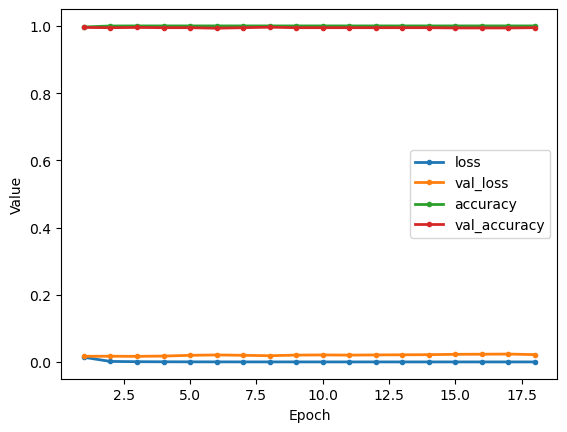

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step

 6/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

11/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

21/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

26/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


 1/52 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step

 6/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

11/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

18/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

21/52 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

26/52 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

31/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [25]:
report.save()

Report saved as Output/Reports/SBP/report_S53HFLQT.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################